In [ ]:
### purpose: Plot "Splicing per intron" (SPI) (Figure 5A) and overlap of
#            genes with significantly altered introns with genese altered in exon splicing (Figure S4A)

## input: first run spliceq (see method part of manuscript), then run calculateSPI.py as follows: 
    # python calculateSPI.py \
    # -out eif4a3_nSmash_SPI \
    # -condition1 ctr \
    # -condition2 kd \
    # -m manifest.tsv \               ###(see example manifest)
    # -filePath path/to/spliceq/output
#  this generates a file SPI_for_ctr_vs_kd.tsv used as input here. In addition a gtf file is needed.
#  To generate venn diagram you need outputs from scripts 1 and 3.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns
import matplotlib.colors as mcolors

In [2]:
spi = pd.read_csv('SPI_for_ctr_vs_kd.tsv', delimiter = '\t')
gtf_file = 'gencode.v44.basic.annotation.gtf'

In [5]:
#add a significance column:

# Define conditions
conditions = [
    (spi['padj'] <= 0.01) & (spi['dSPI'] >= 0.1),
    (spi['padj'] <= 0.01) & (spi['dSPI'] <= -0.1)
]

# Define choices
choices = ['higher_SPI', 'lower_SPI']

# Apply conditions
spi['significant'] = np.select(conditions, choices, default='not_significant')


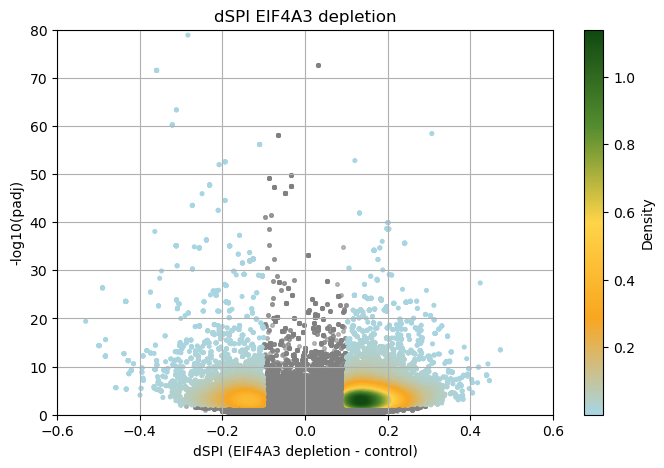

In [6]:
# Define custom colors
custom_colors = ["#A8D5E2", "#F9A620", "#FFD449", "#548C2F", "#104911"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)

# Define conditions for high and low SPI compared to control
high = spi['significant'] == 'higher_SPI'
low = spi['significant'] == 'lower_SPI'

# Convert padj to -log10(padj) (handle zero values safely)
spi['neg_log10_padj'] = -np.log10(spi['padj'].replace(0, np.nan))

# Compute density only for highlighted points
highlighted = spi.loc[high | low]
xy_highlighted = np.vstack([highlighted['dSPI'], highlighted['neg_log10_padj']])
density_highlighted = gaussian_kde(xy_highlighted)(xy_highlighted)

# Normalize density values for better color mapping
norm = mcolors.Normalize(vmin=density_highlighted.min(), vmax=density_highlighted.max())

# Sort highlighted points by density for better visualization
sorted_indices = density_highlighted.argsort()
highlighted_sorted = highlighted.iloc[sorted_indices]
density_sorted = density_highlighted[sorted_indices]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Scatter plot for non-highlighted points (gray, transparent)
ax.scatter(spi.loc[~(high | low), 'dSPI'], 
           spi.loc[~(high | low), 'neg_log10_padj'], 
           s=7, color='gray', alpha=0.5)

# Scatter plot for highlighted points with density coloring
sc = ax.scatter(highlighted_sorted['dSPI'], highlighted_sorted['neg_log10_padj'], 
                c=density_sorted, s=7, cmap=custom_cmap, norm=norm)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Density')

# Customize plot
ax.set_xlabel('dSPI (EIF4A3 depletion - control)')
ax.set_ylabel('-log10(padj)')
ax.set_title('dSPI EIF4A3 depletion')
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(0, 80)
ax.grid(True)

# # Save figures
plt.savefig('volcano_dSPI_padj_0.01_dSPI_0.1.pdf')
plt.savefig('volcano_dSPI_padj_0.01_dSPI_0.1.png')

# Show plot
plt.show()

In [7]:
# Count the number of entries in each condition
num_high = high.sum()  # Count of 'higher_SPI'
num_low = low.sum()    # Count of 'lower_SPI'

# Print results
print(f"Number of 'higher_SPI' (high condition): {num_high}")
print(f"Number of 'lower_SPI' (low condition): {num_low}")


Number of 'higher_SPI' (high condition): 17569
Number of 'lower_SPI' (low condition): 7640


In [13]:
### ADD GENE_NAMES 
def parse_gtf_for_gene_names(gtf_file):
    """
    Parses GTF file to extract transcript_id and gene_name.
    """
    # Load GTF file, skipping comment lines
    gtf_df = pd.read_csv(gtf_file, sep='\t', comment='#', header=None, names=[
        'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])
    
    # Extract transcript_id and gene_name from attribute column
    gtf_df['transcript_id'] = gtf_df['attribute'].str.extract(r'transcript_id "([^"]+)"')
    gtf_df['gene_name'] = gtf_df['attribute'].str.extract(r'gene_name "([^"]+)"')

    # Keep only unique mappings of transcript_id to gene_name
    gtf_df = gtf_df[['transcript_id', 'gene_name']].drop_duplicates()

    return gtf_df

def add_gene_names_to_spi(spi_df, gtf_df):
    """
    Adds gene_name to spi DataFrame by merging with GTF transcript-gene mappings.
    """
    return spi_df.merge(gtf_df, on="transcript_id", how="left")


In [14]:
gtf_data = parse_gtf_for_gene_names(gtf_file)


In [15]:
spi.rename(columns={'transcript_ID': 'transcript_id'}, inplace=True)
spi = add_gene_names_to_spi(spi, gtf_data)


In [8]:
spi.to_csv('SPI_all_introns_nRNA_eif4a3_smash_SRS.csv', index=False)

In [17]:
# Create spi_sig by filtering for significant entries
spi_sig = spi[spi['significant'].isin(['higher_SPI', 'lower_SPI'])].copy()


In [19]:
### --- Find gene_name overlap with whippet outputs----

block_ex = pd.read_csv('block_exons_ddPSImax0.2_adjacent.csv')
whippet = pd.read_csv('sig_whip_CE_prob0.9_dPSI0.1.csv')

single = whippet[~whippet['gene_name'].isin(block_ex['gene_name'])].copy()


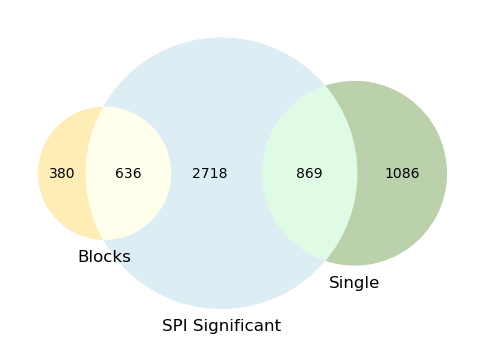

In [20]:
# Define custom colors
custom_colors = ["#A8D5E2", "#FFD449", "#548C2F"]

# Extract unique gene names from each dataframe
genes_spi_sig = set(spi_sig['gene_name'].dropna().unique())
genes_blocks = set(block_ex['gene_name'].dropna().unique())
genes_single = set(single['gene_name'].dropna().unique())

# Create the Venn diagram
plt.figure(figsize=(6,6))
venn = venn3(
    [genes_spi_sig, genes_blocks, genes_single], 
    set_labels=('SPI Significant', 'Blocks', 'Single'),
    set_colors=custom_colors  
)

plt.savefig('overlap_dPSI_dSPI.pdf')
plt.show()
